In [3]:
!pip install filterpy

  Using cached filterpy-1.4.5.zip (177 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110542 sha256=ed8b75fcc0dfdb18724032955c99d4d5657673b33bf3bbd098312aa1b2a5b174
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\12\dc\3c\e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


In [7]:
import time
import threading
import requests
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
from filterpy.kalman import KalmanFilter

BASE_URL = "https://fleetbots-production.up.railway.app/api"
VALID_TASKS = ["Soil Analysis", "Irrigation", "Weeding", "Crop Monitoring"]
VALID_DIRECTIONS = ["forward", "backward", "left", "right"]
LOW_MOISTURE_THRESHOLD = 30.0
HIGH_TEMPERATURE_THRESHOLD = 35.0
LOW_BATTERY_THRESHOLD = 20

# =================== SLAM Implementation ===================
class KalmanSLAM:
    """Kalman-based SLAM for rover position estimation"""
    
    def __init__(self, rover_id):
        self.rover_id = rover_id
        self.kf = KalmanFilter(dim_x=4, dim_z=2)  # 4 state vars (x, y, vx, vy), 2 sensor readings (x, y)

        # State transition matrix (assumes constant velocity)
        self.kf.F = np.array([[1, 0, 1, 0],
                              [0, 1, 0, 1],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])

        # Measurement function (we only observe x, y)
        self.kf.H = np.array([[1, 0, 0, 0],
                              [0, 1, 0, 0]])

        # Measurement noise (sensor error)
        self.kf.R *= 5  

        # Process noise (random movement variations)
        self.kf.Q *= 0.01  

        # Initial state (rover starts at 0,0 with no velocity)
        self.kf.x = np.array([0, 0, 0, 0])

        self.estimated_path = []

    def update_position(self, measurement):
        """Update SLAM position using sensor data"""
        self.kf.predict()
        self.kf.update(measurement)
        self.estimated_path.append(self.kf.x[:2])

    def plot_path(self):
        """Plot SLAM-based estimated path"""
        path = np.array(self.estimated_path)
        plt.plot(path[:, 0], path[:, 1], marker="o", linestyle="-", color="blue", label=f"{self.rover_id} Path")
        plt.title(f"SLAM for {self.rover_id}")
        plt.xlabel("X Grid")
        plt.ylabel("Y Grid")
        plt.legend()
        plt.grid()

# Store SLAM instances for each rover
slam_map = {f"Rover-{i}": KalmanSLAM(f"Rover-{i}") for i in range(1, 6)}

# =================== API Calls ===================
def start_session():
    url = f"{BASE_URL}/session/start"
    try:
        response = requests.post(url, timeout=5)
        response.raise_for_status()
        data = response.json()
        print(f"[Session] {data.get('message')}")
        return data.get("session_id")
    except requests.RequestException as e:
        print(f"[Error] Starting session: {e}")
        return None

def get_fleet_status(session_id):
    url = f"{BASE_URL}/fleet/status?session_id={session_id}"
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Fetching fleet status: {e}")
        return None

def fetch_sensor_data(rover_id, session_id):
    url = f"{BASE_URL}/rover/{rover_id}/sensor-data?session_id={session_id}"
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Fetching {rover_id} sensor data: {e}")
        return None

# =================== Task Management ===================
def assign_task(rover_id, session_id, task):
    task = task.title()
    if task not in VALID_TASKS:
        print(f"[Error] Invalid task. Choose from {VALID_TASKS}")
        return None

    url = f"{BASE_URL}/rover/{rover_id}/task"
    params = {"session_id": session_id, "task": task}

    try:
        response = requests.post(url, params=params, timeout=5)
        response.raise_for_status()
        print(f"[Task] {task} assigned to {rover_id}")
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Assigning task to {rover_id}: {e}")
        return None

# =================== Monitoring & SLAM Loop ===================
def monitoring_loop(session_id, scheduler):
    base_interval = 10  
    while True:
        try:
            fleet_status = get_fleet_status(session_id)
            print(f"\n[Monitoring] Fleet Status:")

            if fleet_status:
                for rover_id, details in fleet_status.items():
                    battery = details['battery']
                    task = details.get('task', 'None')
                    print(f"🔹 {rover_id} → Status: {details['status']} | Battery: {battery}% | Task: {task}")

            print("[Monitoring] Checking sensor data...")
            for rover_id in [f"Rover-{i}" for i in range(1, 6)]:
                sensor_data = fetch_sensor_data(rover_id, session_id)
                if sensor_data:
                    moisture = sensor_data['soil_moisture']
                    pH = sensor_data['soil_pH']
                    temperature = sensor_data['temperature']
                    x, y = sensor_data.get('position', (0, 0))  # Simulated position data
                    
                    print(f"🌱 {rover_id} Sensor → Moisture: {moisture:.2f}% | pH: {pH:.2f} | Temp: {temperature:.2f}°C")

                    if moisture < LOW_MOISTURE_THRESHOLD:
                        print(f"[Alert] {rover_id} detected low moisture ({moisture:.2f}%). Assigning irrigation.")
                        scheduler.add_task(rover_id, "Irrigation", priority=1)

                    if temperature > HIGH_TEMPERATURE_THRESHOLD:
                        print(f"[Warning] {rover_id} detected high temperature ({temperature:.2f}°C).")

                    # Update SLAM with new sensor-based position
                    slam_map[rover_id].update_position(np.array([x, y]))

            scheduler.process_tasks(session_id)
            time.sleep(base_interval)

        except Exception as e:
            print(f"[Error] Monitoring error: {e}")
            time.sleep(5)

# =================== Task Scheduler ===================
class TaskScheduler:
    def __init__(self):
        self.task_queue = PriorityQueue()

    def add_task(self, rover_id, task_type, priority):
        self.task_queue.put((priority, time.time(), rover_id, task_type))
        print(f"[Task] {task_type} added for {rover_id} with priority {priority}")

    def process_tasks(self, session_id):
        while not self.task_queue.empty():
            priority, _, rover_id, task = self.task_queue.get()
            assign_task(rover_id, session_id, task)

# =================== Main Function ===================
def main():
    print("\n=== 🚜 Agricultural Fleet Management System with SLAM ===")
    
    session_id = start_session()
    if not session_id:
        print("[Error] Failed to initialize system")
        return

    scheduler = TaskScheduler()
    monitor_thread = threading.Thread(target=monitoring_loop, args=(session_id, scheduler), daemon=True)
    monitor_thread.start()

    while True:
        try:
            cmd = input("\n> ").strip().lower()
            if cmd == 'exit':
                print("Shutting down system...")
                break
            elif cmd == 'slam':
                for rover in slam_map.values():
                    rover.plot_path()
                    plt.show()
            else:
                print("[Error] Invalid command.")
        except KeyboardInterrupt:
            print("\nShutting down...")
            break

if __name__ == "__main__":
    main()



=== 🚜 Agricultural Fleet Management System with SLAM ===
[Session] Session started. Use this ID for API calls.

[Monitoring] Fleet Status:
🔹 Rover-1 → Status: idle | Battery: 69% | Task: None
🔹 Rover-2 → Status: idle | Battery: 73% | Task: None
🔹 Rover-3 → Status: idle | Battery: 70% | Task: None
🔹 Rover-4 → Status: idle | Battery: 92% | Task: None
🔹 Rover-5 → Status: idle | Battery: 80% | Task: None
[Monitoring] Checking sensor data...
🌱 Rover-1 Sensor → Moisture: 77.31% | pH: 6.17 | Temp: 35.07°C
[Warning] Rover-1 detected high temperature (35.07°C).
🌱 Rover-2 Sensor → Moisture: 67.05% | pH: 5.76 | Temp: 33.38°C
🌱 Rover-3 Sensor → Moisture: 53.45% | pH: 5.59 | Temp: 22.27°C
🌱 Rover-4 Sensor → Moisture: 62.70% | pH: 5.92 | Temp: 33.19°C
🌱 Rover-5 Sensor → Moisture: 47.66% | pH: 5.60 | Temp: 11.61°C

[Monitoring] Fleet Status:
🔹 Rover-1 → Status: idle | Battery: 69% | Task: None
🔹 Rover-2 → Status: idle | Battery: 73% | Task: None
🔹 Rover-3 → Status: idle | Battery: 70% | Task: None
🔹

In [9]:
pip install numpy matplotlib filterpy

🌱 Rover-4 Sensor → Moisture: 32.13% | pH: 6.44 | Temp: 18.18°C
🌱 Rover-5 Sensor → Moisture: 38.64% | pH: 6.35 | Temp: 13.52°C
Note: you may need to restart the kernel to use updated packages.



=== Agricultural Fleet Management System with SLAM ===
[Session] Session started. Use this ID for API calls.

Command Menu:
  task [rover] [task] - Assign task to a rover
  status - Show fleet status
  exit - Quit program
 Rover-1 Estimated Position: [11.97008973  5.98205384]
 Rover-2 Estimated Position: [13.04775746  1.15866494]
[Alert] Rover-2 detected low moisture (23.70%). Assigning Irrigation.
[Task] Irrigation added for Rover-2 with priority 1
 Rover-3 Estimated Position: [14.03192542  1.05326597]
 Rover-4 Estimated Position: [13.53353555  0.3317583 ]
[Warning] Rover-4 detected high temperature (37.76°C).
 Rover-5 Estimated Position: [12.58109643 -0.20273976]
[Task] Irrigation assigned to Rover-2


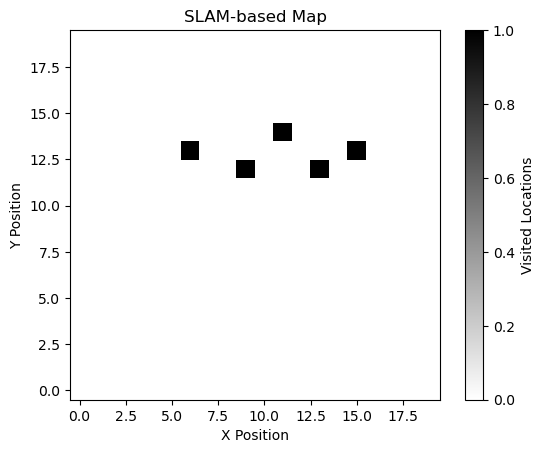


>  task rover-1 Irrigation


 Rover-1 Estimated Position: [14.11782385  0.50015437]
[Alert] Rover-1 detected low moisture (25.77%). Assigning Irrigation.
[Task] Irrigation added for Rover-1 with priority 1
 Rover-2 Estimated Position: [ 6.35654589 -2.83134684]
[Alert] Rover-2 detected low moisture (25.26%). Assigning Irrigation.
[Task] Irrigation added for Rover-2 with priority 1
[Warning] Rover-2 detected high temperature (37.45°C).
[Task] Irrigation assigned to rover-1
 Rover-3 Estimated Position: [ 5.1399432  -2.17880255]
[Warning] Rover-3 detected high temperature (37.80°C).
 Rover-4 Estimated Position: [ 8.20335266 -0.05806796]
 Rover-5 Estimated Position: [ 5.442181   -1.15181402]
[Alert] Rover-5 detected low moisture (25.57%). Assigning Irrigation.
[Task] Irrigation added for Rover-5 with priority 1
[Task] Irrigation assigned to Rover-1
[Task] Irrigation assigned to Rover-2
[Task] Irrigation assigned to Rover-5


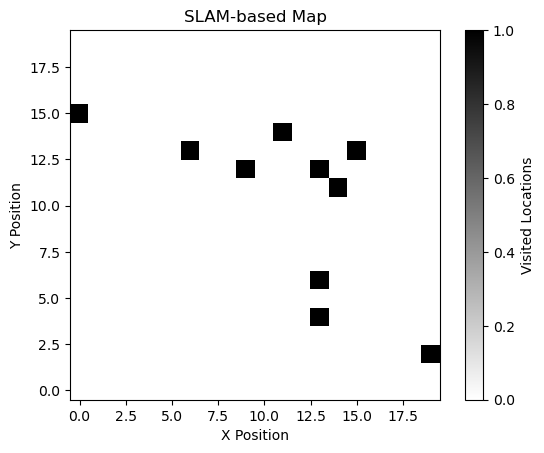

[Error] Fetching Rover-1 sensor data: HTTPSConnectionPool(host='fleetbots-production.up.railway.app', port=443): Read timed out. (read timeout=5)
 Rover-2 Estimated Position: [ 2.79684929 -1.75609231]
 Rover-3 Estimated Position: [ 2.97039815 -0.97540581]
 Rover-4 Estimated Position: [13.08330292  3.51054849]
[Warning] Rover-4 detected high temperature (39.65°C).
 Rover-5 Estimated Position: [12.94634601  2.03489945]


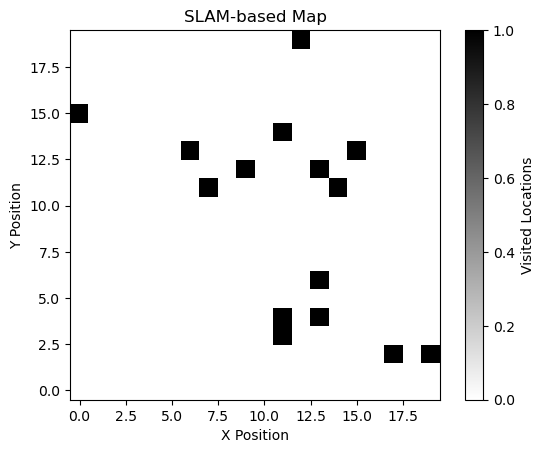

 Rover-1 Estimated Position: [17.601692    3.09503761]
[Alert] Rover-1 detected low moisture (28.93%). Assigning Irrigation.
[Task] Irrigation added for Rover-1 with priority 1
 Rover-2 Estimated Position: [17.63420843  1.85605131]
 Rover-3 Estimated Position: [11.99799095 -1.17505276]
 Rover-4 Estimated Position: [12.24249986 -0.60074885]
 Rover-5 Estimated Position: [ 7.31097132 -2.35282747]
[Task] Irrigation assigned to Rover-1


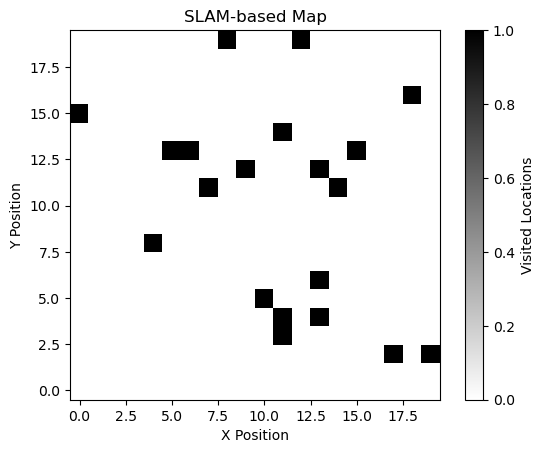

 Rover-1 Estimated Position: [ 3.68132851 -2.8693813 ]
 Rover-2 Estimated Position: [ 2.89072947 -2.02838034]
 Rover-3 Estimated Position: [6.82059    0.38211084]
 Rover-4 Estimated Position: [7.72258287 0.59243651]
 Rover-5 Estimated Position: [7.45755587 0.24553744]
[Warning] Rover-5 detected high temperature (37.19°C).


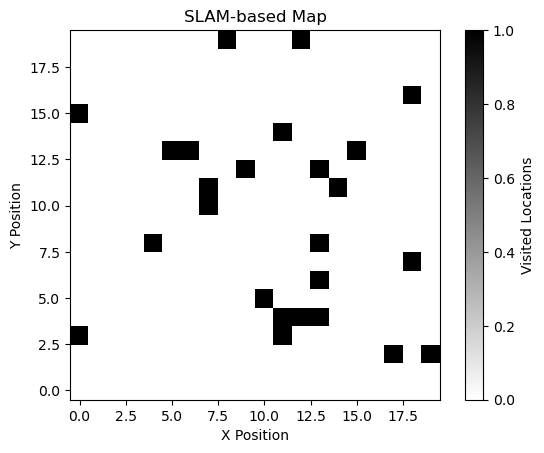

 Rover-1 Estimated Position: [ 3.98436909 -1.25892539]
 Rover-2 Estimated Position: [6.16473869 0.13249037]
 Rover-3 Estimated Position: [6.10341969 0.05408203]
 Rover-4 Estimated Position: [6.70685601 0.27633113]
[Alert] Rover-4 detected low moisture (25.24%). Assigning Irrigation.
[Task] Irrigation added for Rover-4 with priority 1
 Rover-5 Estimated Position: [ 2.42977274 -1.5658175 ]
[Task] Irrigation assigned to Rover-4


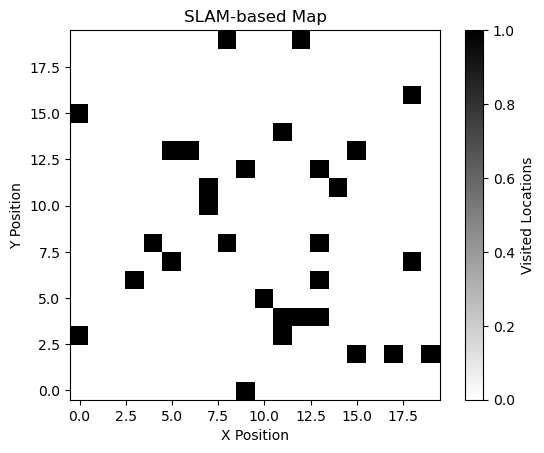

 Rover-1 Estimated Position: [ 0.95266376 -1.5299292 ]
 Rover-2 Estimated Position: [5.66762782 0.99653128]
 Rover-3 Estimated Position: [10.14341496  2.40411377]
 Rover-4 Estimated Position: [14.79872608  3.31486771]
 Rover-5 Estimated Position: [18.03952452  3.28490193]


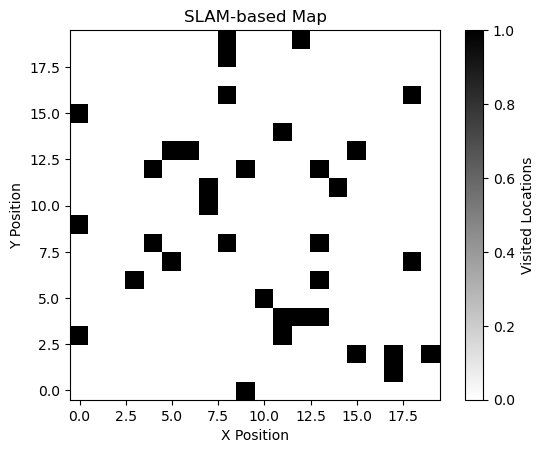

 Rover-1 Estimated Position: [15.89645173  1.08893748]
[Alert] Rover-1 detected low moisture (23.10%). Assigning Irrigation.
[Task] Irrigation added for Rover-1 with priority 1
 Rover-2 Estimated Position: [11.12643115 -1.28138742]
 Rover-3 Estimated Position: [ 8.64197577 -1.76810569]
 Rover-4 Estimated Position: [12.17254477  0.37554859]
 Rover-5 Estimated Position: [10.23454526 -0.56043023]
[Task] Irrigation assigned to Rover-1


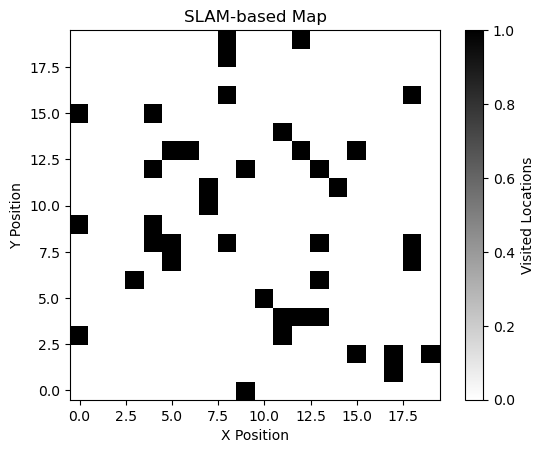

 Rover-1 Estimated Position: [ 6.6263401  -1.79345097]
[Error] Fetching Rover-2 sensor data: HTTPSConnectionPool(host='fleetbots-production.up.railway.app', port=443): Read timed out. (read timeout=5)
 Rover-3 Estimated Position: [ 4.28980053 -2.0131652 ]
[Alert] Rover-3 detected low moisture (29.61%). Assigning Irrigation.
[Task] Irrigation added for Rover-3 with priority 1
 Rover-4 Estimated Position: [ 2.09625418 -2.08614096]
 Rover-5 Estimated Position: [ 0.65557276 -1.82501112]
[Task] Irrigation assigned to Rover-3


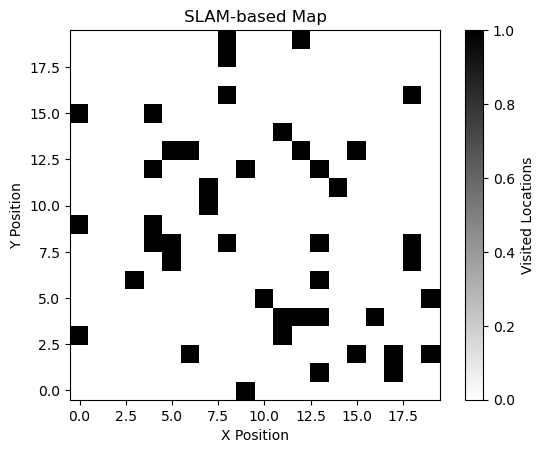

 Rover-1 Estimated Position: [ 0.24515238 -1.25271829]
 Rover-2 Estimated Position: [2.90969086 0.33206371]
 Rover-3 Estimated Position: [13.51697993  4.48905243]
[Alert] Rover-3 detected low moisture (20.26%). Assigning Irrigation.
[Task] Irrigation added for Rover-3 with priority 1
[Warning] Rover-3 detected high temperature (38.78°C).
 Rover-4 Estimated Position: [8.22129046 0.53049578]
[Warning] Rover-4 detected high temperature (35.47°C).
 Rover-5 Estimated Position: [15.43417397  3.23395088]
[Task] Irrigation assigned to Rover-3


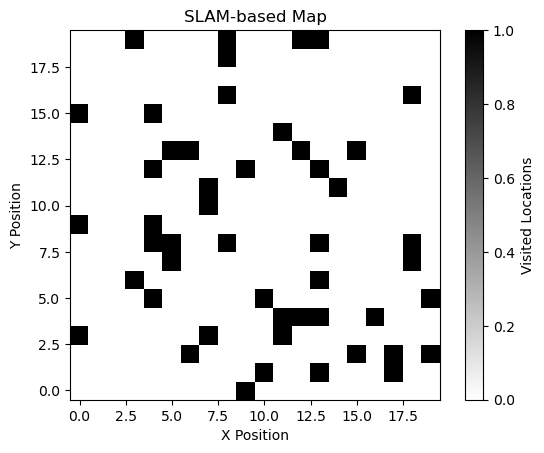

 Rover-1 Estimated Position: [ 7.14755517 -1.42685961]
[Alert] Rover-1 detected low moisture (25.23%). Assigning Irrigation.
[Task] Irrigation added for Rover-1 with priority 1
[Warning] Rover-1 detected high temperature (39.96°C).
 Rover-2 Estimated Position: [ 3.29460151 -2.4083705 ]
 Rover-3 Estimated Position: [ 6.82889961e+00 -4.17931010e-03]
 Rover-4 Estimated Position: [10.1992816   1.36104751]
 Rover-5 Estimated Position: [15.10728772  2.79602012]
[Alert] Rover-5 detected low moisture (26.32%). Assigning Irrigation.
[Task] Irrigation added for Rover-5 with priority 1
[Task] Irrigation assigned to Rover-1
[Task] Irrigation assigned to Rover-5


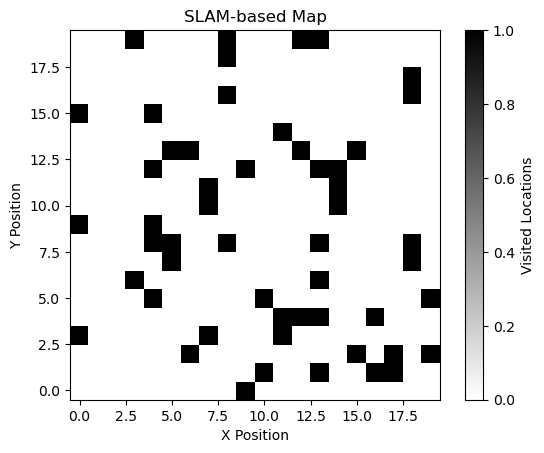


Shutting down...


In [2]:
import time
import threading
import numpy as np
import requests
import matplotlib.pyplot as plt
from queue import PriorityQueue
from filterpy.kalman import KalmanFilter

# === API Configurations ===
BASE_URL = "https://fleetbots-production.up.railway.app/api"
VALID_TASKS = ["Soil Analysis", "Irrigation", "Weeding", "Crop Monitoring"]
VALID_DIRECTIONS = ["forward", "backward", "left", "right"]
LOW_MOISTURE_THRESHOLD = 30.0
HIGH_TEMPERATURE_THRESHOLD = 35.0
LOW_BATTERY_THRESHOLD = 20

# === SLAM: Grid Mapping ===
class GridMap:
    def __init__(self, size=20, resolution=1):
        self.size = size  
        self.resolution = resolution  
        self.grid = np.zeros((size, size))  

    def update(self, x, y, value=1):
        """Mark visited locations on the map."""
        grid_x = int(x / self.resolution)  
        grid_y = int(y / self.resolution)  
        if 0 <= grid_x < self.size and 0 <= grid_y < self.size:
            self.grid[grid_x, grid_y] = value  

    def plot_map(self):
        """Visualize the map."""
        plt.imshow(self.grid, cmap="gray_r", origin="lower")
        plt.title("SLAM-based Map")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.colorbar(label="Visited Locations")
        plt.show()

# === SLAM: Kalman Filter for Localization ===
class RoverSLAM:
    def __init__(self):
        self.kf = KalmanFilter(dim_x=2, dim_z=1)  
        self.kf.x = np.array([[0.], [0.]])  
        self.kf.F = np.array([[1, 1], [0, 1]])  
        self.kf.H = np.array([[1, 0]])  
        self.kf.P *= 1000  
        self.kf.R = 5  

    def update_position(self, measurement):
        """Update position using Kalman Filter."""
        self.kf.predict()
        self.kf.update(measurement)
        return self.kf.x.flatten()  

# === API Calls ===
def start_session():
    url = f"{BASE_URL}/session/start"
    try:
        response = requests.post(url, timeout=5)
        response.raise_for_status()
        data = response.json()
        print(f"[Session] {data.get('message')}")
        return data.get("session_id")
    except requests.RequestException as e:
        print(f"[Error] Starting session: {e}")
        return None

def get_fleet_status(session_id):
    url = f"{BASE_URL}/fleet/status?session_id={session_id}"
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Fetching fleet status: {e}")
        return None

def fetch_sensor_data(rover_id, session_id):
    url = f"{BASE_URL}/rover/{rover_id}/sensor-data?session_id={session_id}"
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Fetching {rover_id} sensor data: {e}")
        return None

def assign_task(rover_id, session_id, task):
    task = task.title()  
    if task not in VALID_TASKS:
        print(f"[Error] Invalid task. Choose from {VALID_TASKS}")
        return None

    url = f"{BASE_URL}/rover/{rover_id}/task"
    params = {"session_id": session_id, "task": task}
    
    try:
        response = requests.post(url, params=params, timeout=5)
        response.raise_for_status()
        print(f"[Task] {task} assigned to {rover_id}")
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Assigning task to {rover_id}: {e}")
        return None

# === Task Scheduler ===
class TaskScheduler:
    def __init__(self):
        self.task_queue = PriorityQueue()

    def add_task(self, rover_id, task_type, priority):
        """Add task with priority"""
        self.task_queue.put((priority, time.time(), rover_id, task_type))
        print(f"[Task] {task_type} added for {rover_id} with priority {priority}")

    def process_tasks(self, session_id):
        """Process tasks in priority order"""
        while not self.task_queue.empty():
            _, _, rover_id, task = self.task_queue.get()
            assign_task(rover_id, session_id, task)

# === Monitoring Loop with SLAM Integration ===
grid_map = GridMap()
slam = RoverSLAM()

def monitoring_loop(session_id, scheduler):
    base_interval = 10  
    while True:
        fleet_status = get_fleet_status(session_id)
        if fleet_status:
            for rover_id, details in fleet_status.items():
                x, y = np.random.randint(0, 20, 2)  
                grid_map.update(x, y)  

                sensor_data = fetch_sensor_data(rover_id, session_id)
                if sensor_data:
                    estimated_pos = slam.update_position(np.array([x]))  
                    print(f" {rover_id} Estimated Position: {estimated_pos}")

                    moisture = sensor_data['soil_moisture']
                    temperature = sensor_data['temperature']

                    if moisture < LOW_MOISTURE_THRESHOLD:
                        print(f"[Alert] {rover_id} detected low moisture ({moisture:.2f}%). Assigning Irrigation.")
                        scheduler.add_task(rover_id, "Irrigation", priority=1)

                    if temperature > HIGH_TEMPERATURE_THRESHOLD:
                        print(f"[Warning] {rover_id} detected high temperature ({temperature:.2f}°C).")

            scheduler.process_tasks(session_id)
            grid_map.plot_map()  
            time.sleep(base_interval)

# === Main Function ===
def main():
    print("\n=== Agricultural Fleet Management System with SLAM ===")
    
    session_id = start_session()
    if not session_id:
        print("[Error] Failed to initialize system")
        return

    scheduler = TaskScheduler()
    monitor_thread = threading.Thread(target=monitoring_loop, args=(session_id, scheduler), daemon=True)
    monitor_thread.start()

    print("\nCommand Menu:")
    print("  task [rover] [task] - Assign task to a rover")
    print("  status - Show fleet status")
    print("  exit - Quit program")

    while True:
        try:
            cmd = input("\n> ").strip().lower()
            parts = cmd.split()

            if cmd == 'exit':
                print("Shutting down system...")
                break

            elif cmd == 'status':
                get_fleet_status(session_id)

            elif len(parts) > 2 and parts[0] == 'task':
                assign_task(parts[1], session_id, " ".join(parts[2:]))

            else:
                print("[Error] Invalid command. Type 'exit' to quit.")

        except KeyboardInterrupt:
            print("\nShutting down...")
            break

if __name__ == "__main__":
    main()



=== Agricultural Fleet Management System with SLAM ===
[Session] Session started. Use this ID for API calls.

Command Menu:
  task [rover] [task] - Assign task to a rover
  move [rover] [direction] - Move a rover
  status - Show fleet status
  exit - Quit program
[Warning] Rover-1 detected high temperature (38.27°C).
[Warning] Rover-3 detected high temperature (36.91°C).
 Rover-1 Estimated Position: [15.96011964  7.97607178]
 Rover-2 Estimated Position: [10.13439777 -5.59778164]
[Alert] Rover-2 detected low moisture (25.83%). Assigning Irrigation.
[Task] Irrigation added for Rover-2 with priority 1


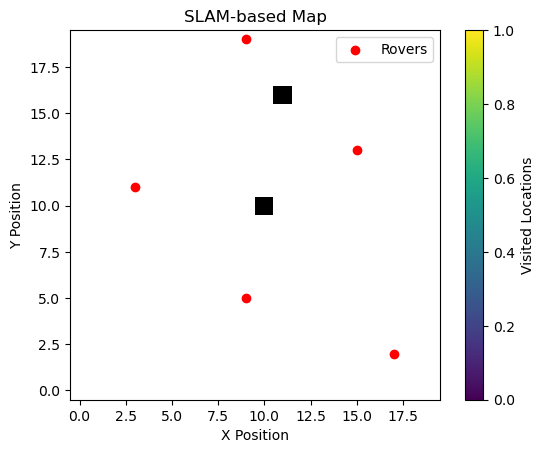

 Rover-3 Estimated Position: [13.38172615 -0.25519301]
 Rover-4 Estimated Position: [16.75303158  1.43110001]
 Rover-5 Estimated Position: [ 8.41879343 -2.63334852]
[Task] Irrigation assigned to Rover-2


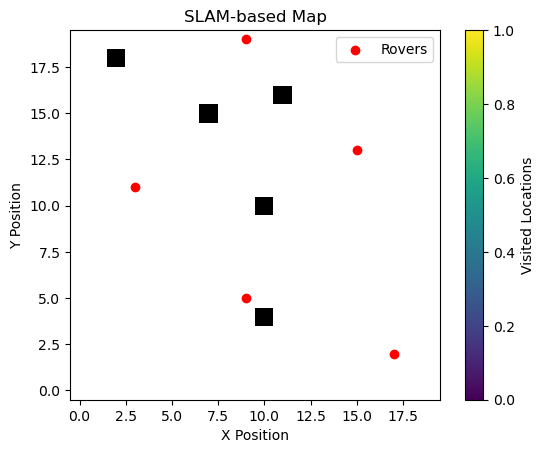

 Rover-1 Estimated Position: [11.2358236  -0.43092744]
[Warning] Rover-1 detected high temperature (35.98°C).


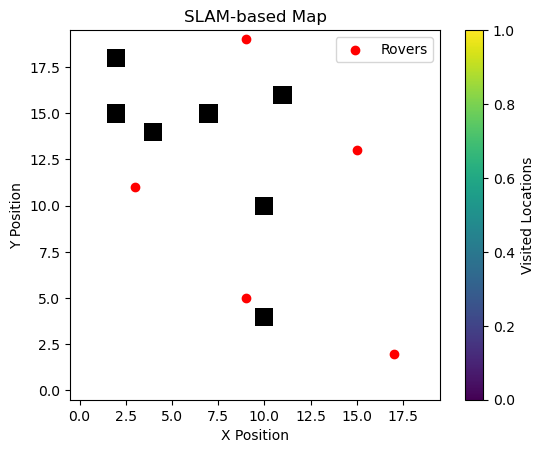

 Rover-2 Estimated Position: [13.55157759  0.67669798]
[Warning] Rover-2 detected high temperature (35.46°C).
 Rover-3 Estimated Position: [ 4.94469065 -3.07494921]
 Rover-4 Estimated Position: [ 3.91101102 -2.24915449]
 Rover-5 Estimated Position: [ 5.14281294 -0.84066899]


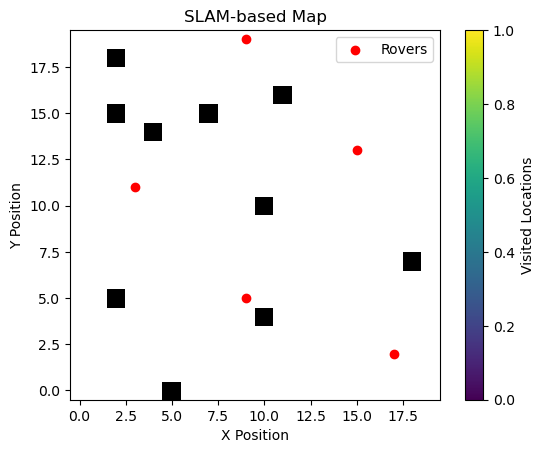

[Alert] Rover-1 detected low moisture (20.96%). Assigning Irrigation.
[Task] Irrigation added for Rover-1 with priority 1
 Rover-1 Estimated Position: [7.36555307 0.39878845]
 Rover-2 Estimated Position: [12.48251586  2.30764854]
 Rover-3 Estimated Position: [10.36255971  0.51638988]
[Warning] Rover-3 detected high temperature (39.80°C).


KeyboardInterrupt: Interrupted by user

In [4]:
import time
import threading
import numpy as np
import requests
import matplotlib.pyplot as plt
from queue import PriorityQueue
from filterpy.kalman import KalmanFilter

# === API Configurations ===
BASE_URL = "https://fleetbots-production.up.railway.app/api"
VALID_TASKS = ["Soil Analysis", "Irrigation", "Weeding", "Crop Monitoring"]
VALID_DIRECTIONS = ["forward", "backward", "left", "right"]
LOW_MOISTURE_THRESHOLD = 30.0
HIGH_TEMPERATURE_THRESHOLD = 35.0
LOW_BATTERY_THRESHOLD = 20

# === SLAM: Grid Mapping ===
class GridMap:
    def __init__(self, size=20, resolution=1):
        self.size = size  
        self.resolution = resolution  
        self.grid = np.zeros((size, size))  
        self.rover_positions = {}  

    def set_initial_position(self, rover_id):
        """Initialize rovers at a fixed starting position"""
        if rover_id not in self.rover_positions:
            self.rover_positions[rover_id] = np.random.randint(0, self.size, 2)

    def move_rover(self, rover_id, direction):
        """Move the rover in a specified direction"""
        if rover_id in self.rover_positions:
            x, y = self.rover_positions[rover_id]

            if direction == "forward":
                y = min(y + 1, self.size - 1)
            elif direction == "backward":
                y = max(y - 1, 0)
            elif direction == "left":
                x = max(x - 1, 0)
            elif direction == "right":
                x = min(x + 1, self.size - 1)

            self.rover_positions[rover_id] = [x, y]
            self.update(x, y)  

    def update(self, x, y, value=1):
        """Mark visited locations on the map."""
        grid_x = int(x / self.resolution)  
        grid_y = int(y / self.resolution)  
        if 0 <= grid_x < self.size and 0 <= grid_y < self.size:
            self.grid[grid_x, grid_y] = value  

    def plot_map(self):
        """Visualize the map with rover positions"""
        plt.imshow(self.grid, cmap="gray_r", origin="lower")
        plt.scatter(
            [self.rover_positions[r][0] for r in self.rover_positions],
            [self.rover_positions[r][1] for r in self.rover_positions],
            color="red", label="Rovers"
        )
        plt.title("SLAM-based Map")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.legend()
        plt.colorbar(label="Visited Locations")
        plt.show()

# === SLAM: Kalman Filter for Localization ===
class RoverSLAM:
    def __init__(self):
        self.kf = KalmanFilter(dim_x=2, dim_z=1)  
        self.kf.x = np.array([[0.], [0.]])  
        self.kf.F = np.array([[1, 1], [0, 1]])  
        self.kf.H = np.array([[1, 0]])  
        self.kf.P *= 1000  
        self.kf.R = 5  

    def update_position(self, measurement):
        """Update position using Kalman Filter."""
        self.kf.predict()
        self.kf.update(measurement)
        return self.kf.x.flatten()  

# === API Calls ===
def start_session():
    url = f"{BASE_URL}/session/start"
    try:
        response = requests.post(url, timeout=5)
        response.raise_for_status()
        data = response.json()
        print(f"[Session] {data.get('message')}")
        return data.get("session_id")
    except requests.RequestException as e:
        print(f"[Error] Starting session: {e}")
        return None

def get_fleet_status(session_id):
    url = f"{BASE_URL}/fleet/status?session_id={session_id}"
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Fetching fleet status: {e}")
        return None

def fetch_sensor_data(rover_id, session_id):
    url = f"{BASE_URL}/rover/{rover_id}/sensor-data?session_id={session_id}"
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Fetching {rover_id} sensor data: {e}")
        return None

def assign_task(rover_id, session_id, task):
    task = task.title()  
    if task not in VALID_TASKS:
        print(f"[Error] Invalid task. Choose from {VALID_TASKS}")
        return None

    url = f"{BASE_URL}/rover/{rover_id}/task"
    params = {"session_id": session_id, "task": task}
    
    try:
        response = requests.post(url, params=params, timeout=5)
        response.raise_for_status()
        print(f"[Task] {task} assigned to {rover_id}")
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Assigning task to {rover_id}: {e}")
        return None

# === Task Scheduler ===
class TaskScheduler:
    def __init__(self):
        self.task_queue = PriorityQueue()

    def add_task(self, rover_id, task_type, priority):
        """Add task with priority"""
        self.task_queue.put((priority, time.time(), rover_id, task_type))
        print(f"[Task] {task_type} added for {rover_id} with priority {priority}")

    def process_tasks(self, session_id):
        """Process tasks in priority order"""
        while not self.task_queue.empty():
            _, _, rover_id, task = self.task_queue.get()
            assign_task(rover_id, session_id, task)

# === Monitoring Loop with SLAM Integration ===
grid_map = GridMap()
slam = RoverSLAM()

def monitoring_loop(session_id, scheduler):
    base_interval = 10  
    fleet_status = get_fleet_status(session_id)

    if fleet_status:
        for rover_id in fleet_status:
            grid_map.set_initial_position(rover_id)

    while True:
        fleet_status = get_fleet_status(session_id)
        if fleet_status:
            for rover_id in fleet_status:
                sensor_data = fetch_sensor_data(rover_id, session_id)
                if sensor_data:
                    moisture = sensor_data['soil_moisture']
                    temperature = sensor_data['temperature']

                    if moisture < LOW_MOISTURE_THRESHOLD:
                        print(f"[Alert] {rover_id} detected low moisture ({moisture:.2f}%). Assigning Irrigation.")
                        scheduler.add_task(rover_id, "Irrigation", priority=1)

                    if temperature > HIGH_TEMPERATURE_THRESHOLD:
                        print(f"[Warning] {rover_id} detected high temperature ({temperature:.2f}°C).")

            scheduler.process_tasks(session_id)
            grid_map.plot_map()  
            time.sleep(base_interval)

# === Main Function ===
def main():
    print("\n=== Agricultural Fleet Management System with SLAM ===")
    
    session_id = start_session()
    if not session_id:
        print("[Error] Failed to initialize system")
        return

    scheduler = TaskScheduler()
    monitor_thread = threading.Thread(target=monitoring_loop, args=(session_id, scheduler), daemon=True)
    monitor_thread.start()

    print("\nCommand Menu:")
    print("  task [rover] [task] - Assign task to a rover")
    print("  move [rover] [direction] - Move a rover")
    print("  status - Show fleet status")
    print("  exit - Quit program")

    while True:
        cmd = input("\n> ").strip().lower()
        parts = cmd.split()

        if cmd == "exit":
            break
        elif cmd == "status":
            get_fleet_status(session_id)
        elif len(parts) == 3 and parts[0] == "move":
            grid_map.move_rover(parts[1], parts[2])
        else:
            print("[Error] Invalid command.")

if __name__ == "__main__":
    main()



=== Agricultural Fleet Management System with SLAM ===
[Session] Session started. Use this ID for API calls.

Command Menu:
  move [rover] [direction] - Move a rover
  task [rover] [task] - Assign task to a rover
  status - Show fleet status
  exit - Quit program
 Rover-1 Position: (19, 3)
 Rover-2 Position: (17, 13)
 Rover-3 Position: (2, 2)
[Alert] Rover-3 detected low moisture (27.89%). Assigning Irrigation.
[Task] Irrigation added for Rover-3 with priority 1
 Rover-4 Position: (10, 7)
 Rover-5 Position: (3, 10)
[Task] Irrigation assigned to Rover-3


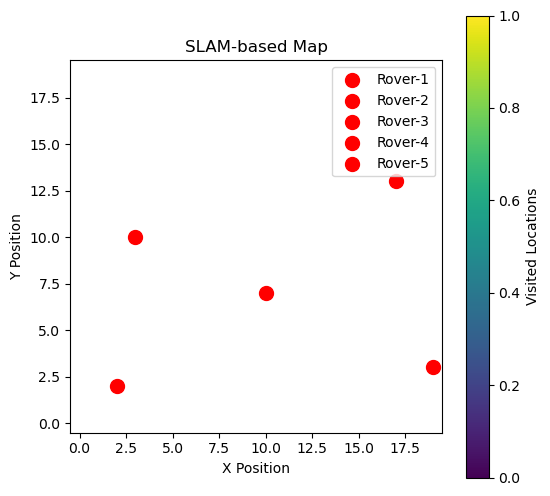

 Rover-1 Estimated Position: [10.97258225  5.48354935]
 Rover-2 Estimated Position: [ 2.13941197 -8.59672592]
[Warning] Rover-3 detected high temperature (38.63°C).
 Rover-3 Estimated Position: [13.37207636  3.38054457]
[Warning] Rover-4 detected high temperature (36.62°C).
 Rover-4 Estimated Position: [ 8.75126088 -0.34002442]
 Rover-5 Estimated Position: [15.01280512  2.40762606]


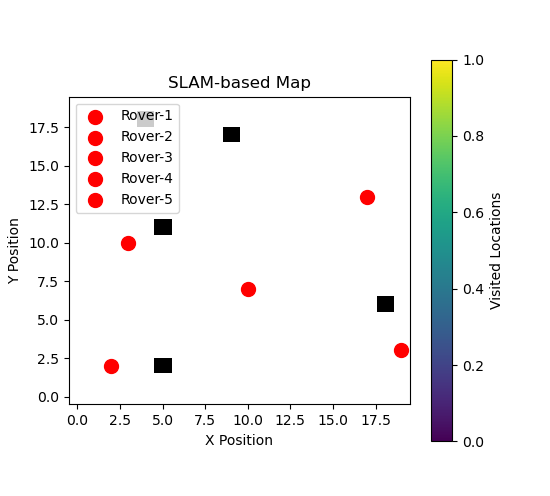

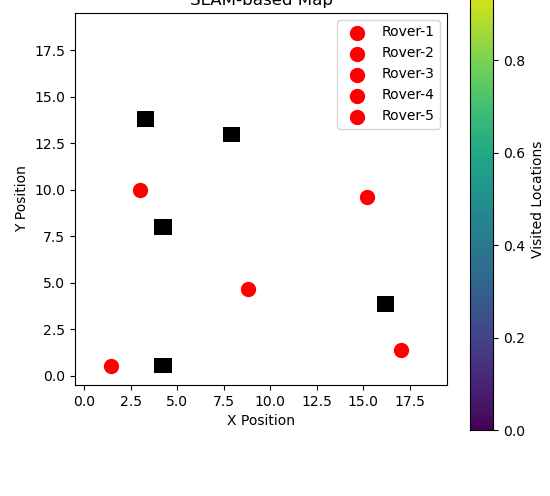

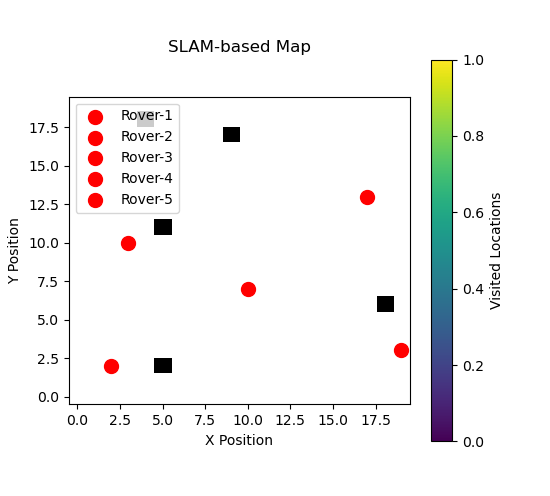

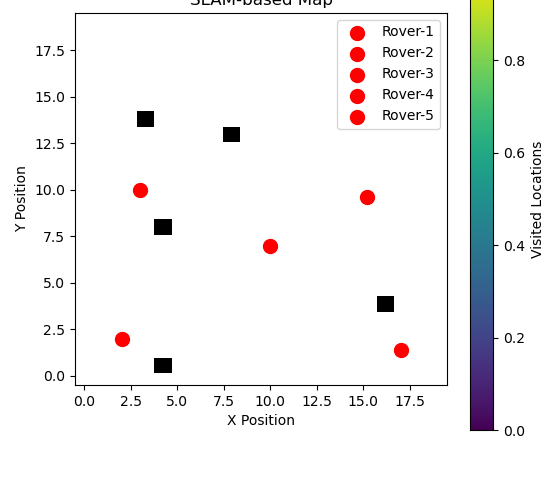

 Rover-1 Position: (19, 3)
[Alert] Rover-1 detected low moisture (28.03%). Assigning Irrigation.
[Task] Irrigation added for Rover-1 with priority 1
[Warning] Rover-1 detected high temperature (35.28°C).
 Rover-2 Position: (17, 13)
[Alert] Rover-2 detected low moisture (23.93%). Assigning Irrigation.
[Task] Irrigation added for Rover-2 with priority 1
 Rover-3 Position: (2, 2)
 Rover-4 Position: (10, 7)
 Rover-5 Position: (3, 10)
[Task] Irrigation assigned to Rover-1
[Task] Irrigation assigned to Rover-2


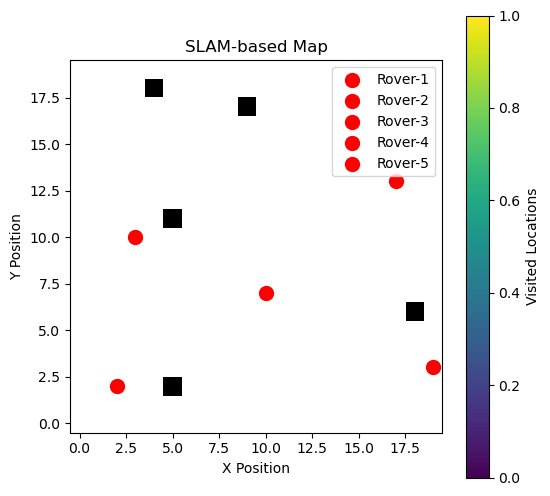

 Rover-1 Estimated Position: [11.16995056 -0.11810491]
[Alert] Rover-4 detected low moisture (27.92%). Assigning Irrigation.
[Task] Irrigation added for Rover-4 with priority 1
[Alert] Rover-5 detected low moisture (27.79%). Assigning Irrigation.
[Task] Irrigation added for Rover-5 with priority 1
 Rover-2 Estimated Position: [12.98210557  0.66029078]
[Task] Irrigation assigned to Rover-4
 Rover-3 Estimated Position: [13.87572356  0.75458209]
[Task] Irrigation assigned to Rover-5


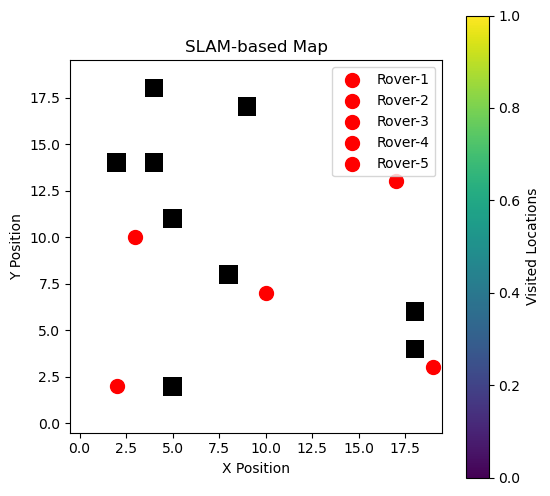

 Rover-4 Estimated Position: [ 7.69818835 -2.04980295]
 Rover-5 Estimated Position: [ 1.96512295 -3.54014673]


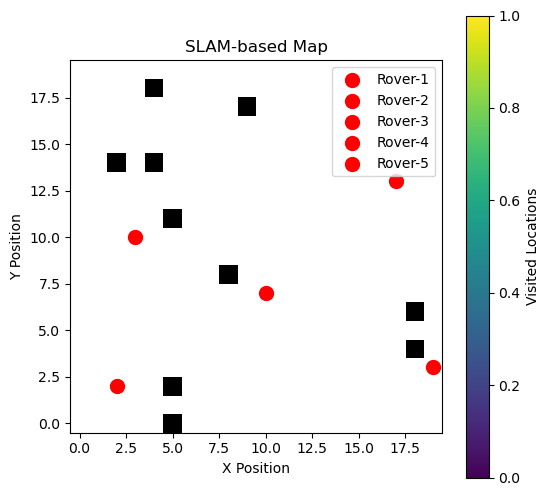

 Rover-1 Position: (19, 3)
 Rover-2 Position: (17, 13)
[Alert] Rover-2 detected low moisture (22.21%). Assigning Irrigation.
[Task] Irrigation added for Rover-2 with priority 1
 Rover-3 Position: (2, 2)
 Rover-4 Position: (10, 7)


KeyboardInterrupt: Interrupted by user

In [6]:
import time
import threading
import numpy as np
import requests
import matplotlib.pyplot as plt
from queue import PriorityQueue
from filterpy.kalman import KalmanFilter

# === API Configurations ===
BASE_URL = "https://fleetbots-production.up.railway.app/api"
VALID_TASKS = ["Soil Analysis", "Irrigation", "Weeding", "Crop Monitoring"]
VALID_DIRECTIONS = ["forward", "backward", "left", "right"]
LOW_MOISTURE_THRESHOLD = 30.0
HIGH_TEMPERATURE_THRESHOLD = 35.0
LOW_BATTERY_THRESHOLD = 20

# === SLAM: Grid Mapping ===
class GridMap:
    def __init__(self, size=20, resolution=1):
        self.size = size  
        self.resolution = resolution  
        self.grid = np.zeros((size, size))  

    def update(self, x, y, value=1):
        """Mark visited locations on the map."""
        grid_x = int(x / self.resolution)  
        grid_y = int(y / self.resolution)  
        if 0 <= grid_x < self.size and 0 <= grid_y < self.size:
            self.grid[grid_x, grid_y] = value  

    def plot_map(self):
        """Visualize the map with rover positions."""
        plt.figure(figsize=(6, 6))
        plt.imshow(self.grid, cmap="gray_r", origin="lower")

        # Plot rovers at their current positions
        for rover_id, (x, y) in rover_positions.items():
            plt.scatter(x, y, color="red", s=100, label=rover_id)

        plt.title("SLAM-based Map")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.legend()
        plt.colorbar(label="Visited Locations")
        plt.show()

# === SLAM: Kalman Filter for Localization ===
class RoverSLAM:
    def __init__(self):
        self.kf = KalmanFilter(dim_x=2, dim_z=1)  
        self.kf.x = np.array([[0.], [0.]])  
        self.kf.F = np.array([[1, 1], [0, 1]])  
        self.kf.H = np.array([[1, 0]])  
        self.kf.P *= 1000  
        self.kf.R = 5  

    def update_position(self, measurement):
        """Update position using Kalman Filter."""
        self.kf.predict()
        self.kf.update(measurement)
        return self.kf.x.flatten()  

# === API Calls ===
def start_session():
    url = f"{BASE_URL}/session/start"
    try:
        response = requests.post(url, timeout=5)
        response.raise_for_status()
        data = response.json()
        print(f"[Session] {data.get('message')}")
        return data.get("session_id")
    except requests.RequestException as e:
        print(f"[Error] Starting session: {e}")
        return None

def get_fleet_status(session_id):
    url = f"{BASE_URL}/fleet/status?session_id={session_id}"
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Fetching fleet status: {e}")
        return None

def fetch_sensor_data(rover_id, session_id):
    url = f"{BASE_URL}/rover/{rover_id}/sensor-data?session_id={session_id}"
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Fetching {rover_id} sensor data: {e}")
        return None

def assign_task(rover_id, session_id, task):
    task = task.title()  
    if task not in VALID_TASKS:
        print(f"[Error] Invalid task. Choose from {VALID_TASKS}")
        return None

    url = f"{BASE_URL}/rover/{rover_id}/task"
    params = {"session_id": session_id, "task": task}
    
    try:
        response = requests.post(url, params=params, timeout=5)
        response.raise_for_status()
        print(f"[Task] {task} assigned to {rover_id}")
        return response.json()
    except requests.RequestException as e:
        print(f"[Error] Assigning task to {rover_id}: {e}")
        return None

# === Task Scheduler ===
class TaskScheduler:
    def __init__(self):
        self.task_queue = PriorityQueue()

    def add_task(self, rover_id, task_type, priority):
        """Add task with priority"""
        self.task_queue.put((priority, time.time(), rover_id, task_type))
        print(f"[Task] {task_type} added for {rover_id} with priority {priority}")

    def process_tasks(self, session_id):
        """Process tasks in priority order"""
        while not self.task_queue.empty():
            _, _, rover_id, task = self.task_queue.get()
            assign_task(rover_id, session_id, task)

# === Rover Positions ===
rover_positions = {f"Rover-{i+1}": (np.random.randint(0, 20), np.random.randint(0, 20)) for i in range(5)}

def update_rover_position(rover_id, direction):
    """Move rover in a specified direction and update map"""
    x, y = rover_positions[rover_id]

    if direction == "forward":
        y += 1
    elif direction == "backward":
        y -= 1
    elif direction == "left":
        x -= 1
    elif direction == "right":
        x += 1

    # Keep within grid limits
    x = max(0, min(19, x))
    y = max(0, min(19, y))

    rover_positions[rover_id] = (x, y)
    grid_map.update(x, y)  # Mark as visited

# === Monitoring Loop ===
grid_map = GridMap()
slam = RoverSLAM()

def monitoring_loop(session_id, scheduler):
    base_interval = 10  
    while True:
        fleet_status = get_fleet_status(session_id)
        if fleet_status:
            for rover_id in fleet_status.keys():
                sensor_data = fetch_sensor_data(rover_id, session_id)
                if sensor_data:
                    print(f" {rover_id} Position: {rover_positions[rover_id]}")

                    moisture = sensor_data['soil_moisture']
                    temperature = sensor_data['temperature']

                    if moisture < LOW_MOISTURE_THRESHOLD:
                        print(f"[Alert] {rover_id} detected low moisture ({moisture:.2f}%). Assigning Irrigation.")
                        scheduler.add_task(rover_id, "Irrigation", priority=1)

                    if temperature > HIGH_TEMPERATURE_THRESHOLD:
                        print(f"[Warning] {rover_id} detected high temperature ({temperature:.2f}°C).")

            scheduler.process_tasks(session_id)
            grid_map.plot_map()  
            time.sleep(base_interval)

# === Main Function ===
def main():
    print("\n=== Agricultural Fleet Management System with SLAM ===")
    
    session_id = start_session()
    if not session_id:
        print("[Error] Failed to initialize system")
        return

    scheduler = TaskScheduler()
    monitor_thread = threading.Thread(target=monitoring_loop, args=(session_id, scheduler), daemon=True)
    monitor_thread.start()

    print("\nCommand Menu:")
    print("  move [rover] [direction] - Move a rover")
    print("  task [rover] [task] - Assign task to a rover")
    print("  status - Show fleet status")
    print("  exit - Quit program")

    while True:
        cmd = input("\n> ").strip().lower()
        parts = cmd.split()

        if cmd == 'exit':
            print("Shutting down system...")
            break
        elif len(parts) == 3 and parts[0] == 'move':
            update_rover_position(parts[1], parts[2])
            grid_map.plot_map()

if __name__ == "__main__":
    main()
